In [2]:
import os
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed
import cProfile
import time
from glob import glob
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import RidgeCV
from isc_standalone import p_from_null
from ISC_Helper import get_rois, _compute_phaseshift_sliding_isc, load_roi_data, parcellate_bold, load_schaeffer1000, parcel_to_nifti
from statsmodels.stats.multitest import multipletests
# %matplotlib inline

/usr/people/ri4541/miniconda3/envs/isc2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
task = 'toystory'
# roi_selected = ['visualcortex', 'auditory', 'vmPFC', 'ACC', 'PCC', 'insula', 'amygdala', 'NA']
roi_selected = ['wholebrain']
# emotions = ['P', 'N', 'M', 'X', 'Cry']  # Positive, Negative, Mixed, Neutral, Cry
emotions = ['P', 'N', 'M']
parcellate = True
avg_over_roi = False
spatial = False
pairwise = False
random_state = None
window_size = 30
step_size = 5

if task == 'toystory':
    n_trs = 288
    n_shifts = 12
elif task == 'onesmallstep':
    n_trs = 454
    n_shifts = 1024
else:
    raise Exception('task not defined')
n_windows = int((n_trs - window_size) / step_size) + 1

smooth = 'smooth'
avg_over_roi_name = "avg" if avg_over_roi else "voxelwise"
spatial_name = "spatial" if spatial else "temporal"
pairwise_name = "pairwise" if pairwise else "group"

# -------------------------------
# File paths
# -------------------------------
amb_aff_path = '/jukebox/norman/rsiyer/isc'
# amb_aff_path = '/Volumes/BCI-1/Ambivalent_Affect'
if task == 'toystory':
    data_dir_func = f'{amb_aff_path}/toystory/nuisance_regressed_cut'
elif task == 'onesmallstep':
    data_dir_func = f'{amb_aff_path}/fMRI_Study/ISC_Data_cut/NuisanceRegressed'
else:
    raise ValueError('Invalid task')
func_fns = glob(join(data_dir_func, 'P?.nii.gz')) + glob(join(data_dir_func, 'N?.nii.gz')) + \
           glob(join(data_dir_func, 'VR?.nii.gz')) + glob(join(data_dir_func, 'P??.nii.gz')) + \
           glob(join(data_dir_func, 'N??.nii.gz')) + glob(join(data_dir_func, 'VR??.nii.gz'))

if task == 'toystory':
    label_dir = f'{amb_aff_path}/VideoLabelling/Toy_Story_Labelled'
elif task == 'onesmallstep':
    label_dir = f'{amb_aff_path}/fMRI_Study/VideoLabelling/OSS_Labelled'

subj_ids = [str(subj).split('/')[-1].split('.')[0] for subj in func_fns]  # assume BIDS format
subj_ids.sort()

roi_mask_path = f'{amb_aff_path}/isc_scripts/rois'
all_roi_fpaths = glob(os.path.join(roi_mask_path, '*.nii*'))
all_roi_masker = get_rois(all_roi_fpaths)
data_path = f'{amb_aff_path}/outputs/{task}/data'
figure_path = f'{amb_aff_path}/isc/outputs/{task}/figures'
parc_path = f"{amb_aff_path}/isc_scripts/schaefer_2018/Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_2mm.nii.gz"
mask_path = f"{data_path}/mask_img.npy"

isc_path = f"{data_path}/isc_sliding_{pairwise_name}_n{len(subj_ids)}_{avg_over_roi_name}_roi{len(roi_selected)}_" \
           f"window{window_size}_step{step_size}.pkl"

sliding_perm_path = f"{data_path}/sliding_isc/permutations/phaseshift_size{window_size}_step{step_size}"
if parcellate:
    assert avg_over_roi is False
    sliding_perm_path += "parcellated"
    n_parcels = 1000
    parc, masked_parc = load_schaeffer1000(parc_path, mask_path)

In [20]:
# if task == 'onesmallstep':
# roi_selected = roi_selected[1:]

save_path = f"{sliding_perm_path}_{n_shifts}perms_{len(roi_selected)}rois_x"
with open(save_path, 'rb') as f:
    x = pickle.load(f)
    print('permutations loaded from file\n', save_path)

assert list(x.keys()) == roi_selected

permutations loaded from file
 /jukebox/norman/rsiyer/isc/outputs/toystory/data/sliding_isc/permutations/phaseshift_size30_step5parcellated_12perms_1rois_x


In [21]:
x[roi_selected[0]][2].shape

(12, 52, 1000)

In [23]:
label_dir = '/jukebox/norman/rsiyer/isc/VideoLabelling'
coded_states = np.load(f'{label_dir}/coded_states_{task}.npy')
print('shape before trimming:', coded_states.shape)
if task == 'onesmallstep':
    coded_states = coded_states[:, :-30]
elif task == 'toystory':
    coded_states = coded_states[:, :-12]
    
print('shape after trimming:', coded_states.shape)


shape before trimming: (23, 300, 5)
shape after trimming: (23, 288, 5)


In [24]:
timepoint_variance = np.var(coded_states[:, :n_trs, :], axis=0)  # shape=(n_trs, n_emotions)

# Initialize sliding window output
slide_behav = np.zeros((n_windows, timepoint_variance.shape[1]))

# Calculate mean variance within each sliding window
for i in range(n_windows):
    start_idx = i * step_size
    end_idx = start_idx + window_size
    slide_behav[i] = np.mean(timepoint_variance[start_idx:end_idx], axis=0)

In [25]:
print('shape before removing:', slide_behav.shape)  # 8 rois, shape=(n_windows, n_emotions)
# remove crying and neutral to just focus on pos, neg, mix, for 8 rois
slide_behav = slide_behav[:, :3]
# slide_behav = np.delete(slide_behav, 3, axis=1)  # remove neutral
emotions = ['P', 'N', 'M', 'X', 'Cry']
emotions = emotions[:3]
print('shape after removing:', slide_behav.shape)

shape before removing: (52, 5)
shape after removing: (52, 3)


Now that the data is formatted for regression, test the assumptions of linear regression 

In [26]:
# roi_data[2].shape

In [27]:
# # 1. Linearity (correlation between ISC and behavior)
# from scipy.stats import pearsonr
# pearsonr_list = []
# for roi_name, roi_data in x.items():
#     # print(roi_data[0][:,0].shape, slide_behav[:, 0].shape)
#     pearsonr_list.append(pearsonr(roi_data[0][:,0], slide_behav[:, 0])[0])
#     pearsonr_list.append(pearsonr(roi_data[0][:,0], slide_behav[:, 1])[0])
#     pearsonr_list.append(pearsonr(roi_data[0][:,0], slide_behav[:, 2])[0])

# print()
# print('pearsonr_list:', len(pearsonr_list))
# print('mean:', np.mean(pearsonr_list))
# print('std:', np.std(pearsonr_list))

In [28]:
x['wholebrain'][2].shape

(12, 52, 1000)

In [29]:
if parcellate:
    true_coefs = np.empty(shape=(n_parcels, len(emotions)))
    true_means = []
    true_stds = []
    true_r2s = []
    for parcel in range(n_parcels):
        true_isc_data = x['wholebrain'][0][:, parcel]  # observed, only need p and distribution for perm testing ISC
        alpha_range = np.logspace(-3, 3, 100)
        model = RidgeCV(alphas=alpha_range, store_cv_values=True)
        results = model.fit(slide_behav, true_isc_data)
        mses = results.cv_values_
        true_coefs[parcel] = results.coef_
        mean_mses = np.mean(mses, axis=0)
        std_mses = np.std(mses, axis=0)

        true_means.append(mean_mses[np.argmin(mean_mses)])
        true_stds.append(std_mses[np.argmin(std_mses)])
        true_r2s.append(model.score(slide_behav, true_isc_data))
    # [print(f"emotion consensus explains {true_r2s[r]:.2f} of variance in {roi} synchrony") for r, roi in enumerate(roi_selected)]
else:
    true_coefs = np.empty(shape=(len(roi_selected), len(emotions)))
    true_means = []
    true_stds = []
    true_r2s = []
    for r, roi in enumerate(roi_selected):
        true_isc_data = x[roi][0].flatten()  # observed, only need p and distribution for perm testing ISC
        alpha_range = np.logspace(-3, 3, 100)
        model = RidgeCV(alphas=alpha_range, store_cv_values=True)
        results = model.fit(slide_behav, true_isc_data)
        mses = results.cv_results_
        true_coefs[r] = results.coef_
        mean_mses = np.mean(mses, axis=0)
        std_mses = np.std(mses, axis=0)

        true_means.append(mean_mses[np.argmin(mean_mses)])
        true_stds.append(std_mses[np.argmin(std_mses)])
        true_r2s.append(model.score(slide_behav, true_isc_data))
    [print(f"emotion consensus explains {true_r2s[r]:.2f} of variance in {roi} synchrony") for r, roi in enumerate(roi_selected)]

In [30]:
x['wholebrain'][0][0].shape

(1000,)

In [33]:
if parcellate:
    perm_coefs = np.empty(shape=(n_parcels, n_shifts, len(emotions)))
    perm_means = []
    perm_stds = []
    perm_r2s = np.empty(shape=(n_parcels, n_shifts))

    for parcel in tqdm(range(n_parcels), total=n_parcels):
        coefs = []
        means = []
        stds = []
        r2s = []
        for perm in range(n_shifts):
            shifted_isc_data = x['wholebrain'][-1][perm][:, parcel]  # observed, only need p and distribution for perm testing ISC
            alpha_range = np.logspace(-3, 3, 100)
            model = RidgeCV(alphas=alpha_range, store_cv_values=True)
            results = model.fit(slide_behav, shifted_isc_data)
            mses = results.cv_values_  # contains mean squared error for each alpha
            mean_mses = np.mean(mses, axis=0)
            std_mses = np.std(mses, axis=0)

            coefs.append(results.coef_)
            means.append(mean_mses[np.argmin(mean_mses)])
            stds.append(std_mses[np.argmin(std_mses)])
            r2s.append(model.score(slide_behav, shifted_isc_data))

        perm_coefs[parcel] = coefs
        perm_means.append(means)
        perm_stds.append(stds)
        perm_r2s[parcel] = r2s
else:
    perm_coefs = np.empty(shape=(len(roi_selected), n_shifts, len(emotions)))
    perm_means = []
    perm_stds = []
    perm_r2s = np.empty(shape=(len(roi_selected), n_shifts))

    for r, roi in tqdm(enumerate(roi_selected), total=len(roi_selected)):
        coefs = []
        means = []
        stds = []
        r2s = []
        for perm in range(n_shifts):
            shifted_isc_data = x[roi][-1][perm].flatten()  # observed, only need p and distribution for perm testing ISC
            alpha_range = np.logspace(-3, 3, 100)
            model = RidgeCV(alphas=alpha_range, store_cv_values=True)
            results = model.fit(slide_behav, shifted_isc_data)
            mses = results.cv_values_  # contains mean squared error for each alpha
            mean_mses = np.mean(mses, axis=0)
            std_mses = np.std(mses, axis=0)

            coefs.append(results.coef_)
            means.append(mean_mses[np.argmin(mean_mses)])
            stds.append(std_mses[np.argmin(std_mses)])
            r2s.append(model.score(slide_behav, shifted_isc_data))

        perm_coefs[r] = coefs
        perm_means.append(means)
        perm_stds.append(stds)
        perm_r2s[r] = r2s


100%|██████████| 1000/1000 [01:28<00:00, 11.36it/s]


In [55]:
from concurrent.futures import ProcessPoolExecutor
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import RidgeCV

# Assuming n_parcels, n_shifts, emotions, slide_behav, and x are already defined
perm_coefs = np.empty(shape=(n_parcels, n_shifts, len(emotions)))
perm_means = np.empty((n_parcels, n_shifts))
perm_stds = np.empty((n_parcels, n_shifts))
perm_r2s = np.empty(shape=(n_parcels, n_shifts))

def compute_permutation(parcel):
    coefs = []
    means = []
    stds = []
    r2s = []
    
    for perm in range(n_shifts):
        shifted_isc_data = x['wholebrain'][-1][perm][:, parcel]
        alpha_range = np.logspace(-3, 3, 100)
        model = RidgeCV(alphas=alpha_range, store_cv_values=True)
        results = model.fit(slide_behav, shifted_isc_data)
        mses = results.cv_values_
        mean_mses = np.mean(mses, axis=0)
        std_mses = np.std(mses, axis=0)

        coefs.append(results.coef_)
        means.append(mean_mses[np.argmin(mean_mses)])
        stds.append(std_mses[np.argmin(std_mses)])
        r2s.append(model.score(slide_behav, shifted_isc_data))

    return parcel, coefs, means, stds, r2s

# Run computations in parallel
with ProcessPoolExecutor() as executor:
    results = list(tqdm(executor.map(compute_permutation, range(n_parcels)), total=n_parcels))

# Store results
for parcel, coefs, means, stds, r2s in results:
    perm_coefs[parcel] = coefs
    perm_means[parcel] = means
    perm_stds[parcel] = stds
    perm_r2s[parcel] = r2s


100%|██████████| 1000/1000 [00:11<00:00, 88.42it/s]


In [19]:
# if parcellate:
#     if __name__ == '__main__':
#         perm_coefs, perm_means, perm_stds, perm_r2s = parallel_ridge_cv(
#             x=x,
#             slide_behav=slide_behav,
#             n_parcels=n_parcels,
#             n_shifts=n_shifts,
#             emotions=emotions
#         )

In [34]:
if parcellate:
    p_coef = np.empty(shape=(n_parcels, len(emotions)))
    p_mean = []
    p_std = []
    p_r2 = np.empty(shape=(n_parcels))
    for parcel in tqdm(range(n_parcels), total=n_parcels):
        for e, emo in enumerate(emotions):
            p_coef[parcel][e] = (p_from_null(true_coefs[parcel, e], perm_coefs[parcel,:,e]))
            # p_mean.append(p_from_null(true_means[r], perm_means[r]))
            # p_std.append(p_from_null(true_stds[r], perm_stds[r]))
            p_r2[parcel] = (p_from_null(true_r2s[parcel], perm_r2s[parcel]))

        # p_coef.append(p_roi[roi])

        # p_coef.append(p_from_null(true_coefs[r], perm_coefs[r]))
        # p_mean.append(p_from_null(true_means[r], perm_means[r]))
        # p_std.append(p_from_null(true_stds[r], perm_stds[r]))
        # p_r2.append(p_from_null(true_r2s[r], perm_r2s[r]))

    # return an FDR-corrected p-value map per emotion
    p_fdr = np.empty(shape=p_coef.shape)
    for e, emo in enumerate(emotions):
        _, q, _, _ = multipletests(p_coef[:, e], alpha=0.05, method='fdr_bh')
        p_fdr[:, e] = q
else:
    p_coef = np.empty(shape=(len(roi_selected), len(emotions)))
    p_mean = []
    p_std = []
    p_r2 = np.empty(shape=(len(roi_selected)))
    for r, roi in tqdm(enumerate(roi_selected), total=len(roi_selected)):
        for e, emo in enumerate(emotions):
            p_coef[r][e] = (p_from_null(true_coefs[r, e], perm_coefs[r,:,e]))
            # p_mean.append(p_from_null(true_means[r], perm_means[r]))
            # p_std.append(p_from_null(true_stds[r], perm_stds[r]))
            p_r2[r] = (p_from_null(true_r2s[r], perm_r2s[r]))

        # p_coef.append(p_roi[roi])

        # p_coef.append(p_from_null(true_coefs[r], perm_coefs[r]))
        # p_mean.append(p_from_null(true_means[r], perm_means[r]))
        # p_std.append(p_from_null(true_stds[r], perm_stds[r]))
        # p_r2.append(p_from_null(true_r2s[r], perm_r2s[r]))

    # print the rois that are significant at p < 0.05 for each metric along with the value of the metric, rounded to 2 decimal places
    for r, roi in tqdm(enumerate(roi_selected), total=len(roi_selected)):
        for e, emo in enumerate(emotions):
            if p_coef[r][e] < 0.05/len(roi_selected):
                
                print(f"{roi}, {emo}: Coef = {true_coefs[r, e]:.2f}, p = {p_coef[r][e]:.2f}")
                # print(f"{roi}: Coef = {true_coefs[r]:.2f}, p = {p_coef[r]:.2f}")
        # if p_mean[r] < 0.05:
        #     print(f"{roi}: Mean = {true_means[r]:.2f}, p = {p_mean[r]:.2f}")
        # if p_std[r] < 0.05:
        #     print(f"{roi}: Std = {true_stds[r]:.2f}, p = {p_std[r]:.2f}")
        if p_r2[r] < 0.05/len(roi_selected):
            print(f"{roi}: R2 = {true_r2s[r]:.2f}, p = {p_r2[r]:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16342.82it/s]


In [38]:
import nibabel as nib
parc = nib.load(parc_path)
img = np.zeros(shape=((*parc.shape, len(emotions))))
for p in range(1, n_parcels + 1):
    mask = parc.get_fdata() == p  # location of current parcel
    img[mask, :] = p_fdr[p - 1].T

all_p = nib.Nifti1Image(img, parc.affine)

In [39]:
all_p.shape

(91, 109, 91, 3)

In [42]:
all_p.get_fdata()

271714.7863138591

In [60]:
img = np.zeros(shape=((*parc.shape, len(emotions))))
for p in range(1, n_parcels + 1):
    mask = parc.get_fdata() == p  # location of current parcel
    img[mask, :] = true_coefs[p - 1].T

raw = nib.Nifti1Image(img, parc.affine)

nib.save(raw, f"{data_path}/emotion_coefs_raw")

In [44]:
nib.save(all_p, f"{data_path}/emotion_pvals_corrected")

In [47]:
p_coef_thresholded = np.where(p_fdr < 0.05, true_coefs, 0)

In [49]:
coef = np.zeros(shape=((*parc.shape, len(emotions))))
for p in range(1, n_parcels + 1):
    mask = parc.get_fdata() == p  # location of current parcel
    coef[mask, :] = p_coef_thresholded[p - 1].T

coef_nii = nib.Nifti1Image(coef, parc.affine)

In [50]:
nib.save(coef_nii, f"{data_path}/emotion_betas_corrected")

In [51]:
# all_p = []
# for e in range(len(emotions)):
#     all_p.append(parcel_to_nifti(parc, n_parcels, p_fdr[:,e]))
    

In [52]:
# p_r2, roi_selected

plotting true vs null dist


100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


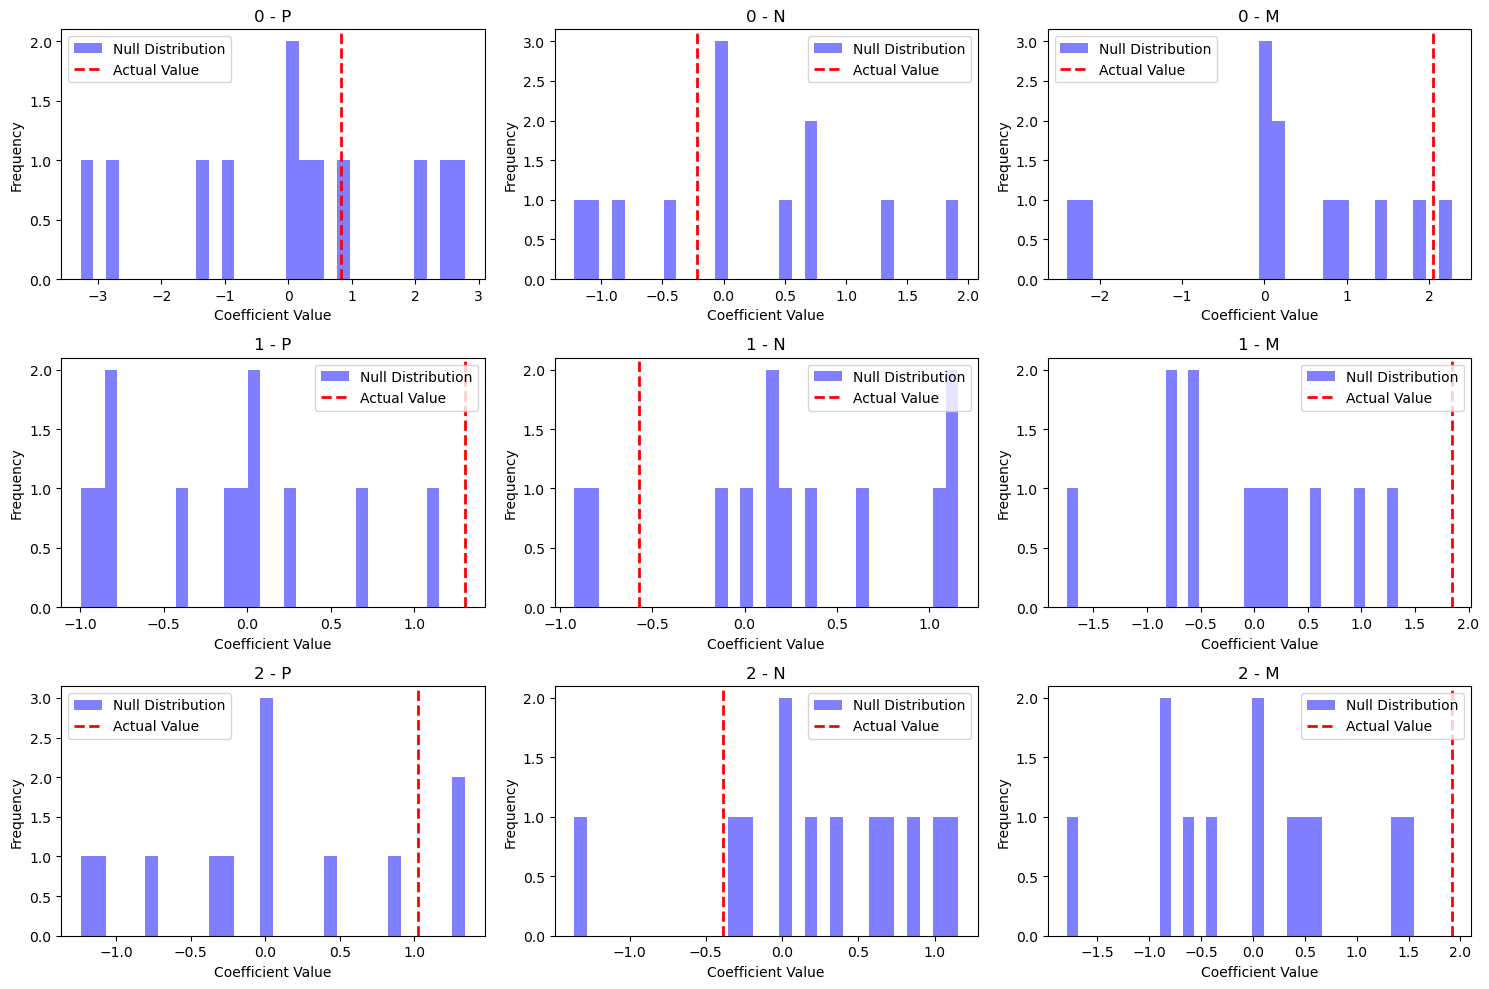

In [53]:
if parcellate:
    num_to_plot = 3
    print('plotting true vs null dist')
    plt.figure(figsize=(15, 10))
    for parcel in tqdm(range(num_to_plot)):
        for e, emo in enumerate(emotions):
            plt.subplot(num_to_plot, len(emotions), parcel * len(emotions) + e + 1)
            plt.hist(perm_coefs[parcel, :, e], bins=30, color='blue', alpha=0.5, label='Null Distribution')
            plt.axvline(true_coefs[parcel, e], color='red', linestyle='dashed', linewidth=2, label='Actual Value')
            plt.title(f"{parcel} - {emo}")
            plt.xlabel('Coefficient Value')
            plt.ylabel('Frequency')
            plt.legend()

    plt.tight_layout()
# plt.savefig(f'{figure_path}/true_vs_null')
else:
    print('plotting true vs null dist')
    plt.figure(figsize=(15, 10))
    for r, roi in tqdm(enumerate(roi_selected), total=len(roi_selected)):
        for e, emo in enumerate(emotions):
            plt.subplot(len(roi_selected), len(emotions), r * len(emotions) + e + 1)
            plt.hist(perm_coefs[r, :, e], bins=30, color='blue', alpha=0.5, label='Null Distribution')
            plt.axvline(true_coefs[r, e], color='red', linestyle='dashed', linewidth=2, label='Actual Value')
            plt.title(f"{roi} - {emo}")
            plt.xlabel('Coefficient Value')
            plt.ylabel('Frequency')
            plt.legend()

    plt.tight_layout()
    # plt.savefig(f'{figure_path}/true_vs_null')

In [ ]:
# plt.figure(figsize=(15, 10))
# for e, emo in enumerate(emotions):
#     plt.subplot(1, len(emotions), e + 1)
#     plt.hist(perm_coefs[0, :, e], bins=100, color='blue', alpha=0.5, label='Null Distribution')
#     plt.axvline(true_coefs[0, e], color='red', linestyle='dashed', linewidth=2, label='Actual Value')
#     plt.title(f"visualcortex - {emo}")
#     plt.xlabel('Coefficient Value')
#     plt.ylabel('Frequency')
#     plt.legend()
# plt.show()
# # plt.savefig(f'{figure_path}/PCC_corr')


In [ ]:
# x[roi][2].shape

In [64]:
# plt.figure()
# for i, e in enumerate(emotions):
#     for r, roi in enumerate(roi_selected):
#         plt.hist(x[roi][0].flatten(), bins=30, color='blue', alpha=0.5)
#         plt.hist(x[roi][2][0], bins=30, color='red', alpha=0.5)
#         plt.title(f"{e} {roi} ISC")
#         plt.show()
